In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)
# testdata = torchvision.datasets.CIFAR10('./CIFAR10',train=False,download=True,transform=transforms.ToTensor())
# print(len(trainingdata),len(testdata))

Files already downloaded and verified


In [4]:
def load_data(is_train,aug,batch_size):
    dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return dataloader

batch_size = 256 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6


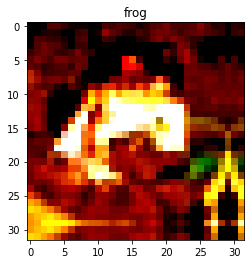

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
print(image.shape, label)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock, [3, 3, 3])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4335434


In [8]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [9]:
num_epochs = 500 # param
epoch_start = 0
path = 'resnet_aug_3block_adam_batch256_lr0001-5e-4.pt'

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()

lr = 0.001
lr_min=0.001
momentum = 0.9
nesterov = True
#optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov)
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4) # changable optimizer
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9) # changable optimizer
optimizer = torch.optim.Adam(model1.parameters(),lr=lr, betas=(0.9,0.999), eps=1e-08, weight_decay=5e-4,amsgrad=False) # changable optimize


if os.path.exists(path):
    checkpoint = torch.load(path)
    print('Read model from checkpoint')
    model1.cuda().load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    train_accuracy_history = checkpoint['train_accuracy_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs+1):
    timestart = time.time()

    train_loss = 0.0
    test_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model1.cuda()(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()
        train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model1.cuda()(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_accu = train_accuracy/len(trainDataLoader)
    test_accu = test_accuracy/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accu)
    test_accuracy_history.append(test_accu)
    print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))

    if epoch % 5 == 0 and epoch != 0:
        torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'train_accuracy_history':train_accuracy_history,
          'test_accuracy_history':test_accuracy_history},path)
        print('Model saved in epoch %s'%(epoch))

Epoch 1, Train loss 1.4945273004016097, Test loss 1.1463000237941743, Train accuracy 43.932557417421926, Test accuracy 58.14453125, Cost 50.82940864562988 s
Epoch 2, Train loss 1.0303460271382818, Test loss 0.895774421095848, Train accuracy 62.95878507653061, Test accuracy 68.583984375, Cost 50.63723635673523 s
Epoch 3, Train loss 0.8460482097401911, Test loss 0.717129009962082, Train accuracy 69.88839285714286, Test accuracy 75.654296875, Cost 50.73088502883911 s
Epoch 4, Train loss 0.7280298036580183, Test loss 0.6699087977409363, Train accuracy 74.7281568877551, Test accuracy 76.09375, Cost 50.725765228271484 s
Epoch 5, Train loss 0.6440915431903333, Test loss 0.6496876642107964, Train accuracy 77.68455038265306, Test accuracy 77.607421875, Cost 50.73975396156311 s
Model saved in epoch 5
Epoch 6, Train loss 0.5803814077255677, Test loss 0.5480439156293869, Train accuracy 79.97249681122449, Test accuracy 81.396484375, Cost 50.63942098617554 s
Epoch 7, Train loss 0.5351561215154979, T

Epoch 52, Train loss 0.18873735627501595, Test loss 0.3095339773222804, Train accuracy 93.44866071428571, Test accuracy 90.1953125, Cost 76.52327847480774 s
Epoch 53, Train loss 0.189097418088694, Test loss 0.31913563795387745, Train accuracy 93.49968112244898, Test accuracy 89.599609375, Cost 74.73674178123474 s
Epoch 54, Train loss 0.1822248828046176, Test loss 0.3074608689174056, Train accuracy 93.61447704081633, Test accuracy 90.576171875, Cost 73.55638790130615 s
Epoch 55, Train loss 0.18629128531533845, Test loss 0.2957735762000084, Train accuracy 93.52758290816327, Test accuracy 90.1953125, Cost 75.37252974510193 s
Model saved in epoch 55
Epoch 56, Train loss 0.1803964482506319, Test loss 0.311426492780447, Train accuracy 93.76116071428571, Test accuracy 89.9609375, Cost 75.87852072715759 s
Epoch 57, Train loss 0.18108801935248228, Test loss 0.29743896387517454, Train accuracy 93.70376275510205, Test accuracy 90.380859375, Cost 73.98275685310364 s
Epoch 58, Train loss 0.17726821

Epoch 103, Train loss 0.14820462647749452, Test loss 0.30397849455475806, Train accuracy 94.94897959183673, Test accuracy 90.0390625, Cost 78.23442077636719 s
Epoch 104, Train loss 0.14264244553918132, Test loss 0.30512716211378577, Train accuracy 95.0960618622449, Test accuracy 90.693359375, Cost 77.08882737159729 s
Epoch 105, Train loss 0.1418994806174721, Test loss 0.30414925925433633, Train accuracy 95.15106823979592, Test accuracy 90.771484375, Cost 76.10817265510559 s
Model saved in epoch 105
Epoch 106, Train loss 0.15162496417000584, Test loss 0.3132373087108135, Train accuracy 94.77319834183673, Test accuracy 89.921875, Cost 75.53187227249146 s
Epoch 107, Train loss 0.14533254428177464, Test loss 0.31514660380780696, Train accuracy 94.99123086734694, Test accuracy 90.29296875, Cost 77.03588390350342 s
Epoch 108, Train loss 0.14861786107019503, Test loss 0.29671079814434054, Train accuracy 94.94738520408163, Test accuracy 90.673828125, Cost 76.20717525482178 s
Epoch 109, Train l

Epoch 154, Train loss 0.13218082065637016, Test loss 0.3304172016680241, Train accuracy 95.44323979591837, Test accuracy 89.814453125, Cost 77.00537896156311 s
Epoch 155, Train loss 0.12956190846708357, Test loss 0.3199274528771639, Train accuracy 95.50581951530613, Test accuracy 90.537109375, Cost 78.66475081443787 s
Model saved in epoch 155
Epoch 156, Train loss 0.13753521292261323, Test loss 0.3291075903922319, Train accuracy 95.26945153061224, Test accuracy 89.560546875, Cost 79.21748495101929 s
Epoch 157, Train loss 0.1352745841770452, Test loss 0.33095807284116746, Train accuracy 95.39421237244898, Test accuracy 90.234375, Cost 78.2888069152832 s
Epoch 158, Train loss 0.13389107984091556, Test loss 0.3172810785472393, Train accuracy 95.4053730867347, Test accuracy 90.13671875, Cost 78.31592392921448 s
Epoch 159, Train loss 0.13750610652626777, Test loss 0.3076432287693024, Train accuracy 95.25271045918367, Test accuracy 90.771484375, Cost 72.05554866790771 s
Epoch 160, Train loss

Epoch 205, Train loss 0.126236034709276, Test loss 0.32960809506475924, Train accuracy 95.75215242346938, Test accuracy 90.185546875, Cost 75.40699076652527 s
Model saved in epoch 205
Epoch 206, Train loss 0.12366595208568841, Test loss 0.31087286323308944, Train accuracy 95.6592793367347, Test accuracy 90.76171875, Cost 77.88305234909058 s
Epoch 207, Train loss 0.13102630250231953, Test loss 0.33640436753630637, Train accuracy 95.43965242346938, Test accuracy 89.853515625, Cost 76.11836242675781 s
Epoch 208, Train loss 0.13225376702921124, Test loss 0.32600893676280973, Train accuracy 95.40019132653062, Test accuracy 90.0, Cost 76.97877740859985 s
Epoch 209, Train loss 0.1255449696577021, Test loss 0.28795807911083104, Train accuracy 95.64253826530613, Test accuracy 90.99609375, Cost 72.3986976146698 s
Epoch 210, Train loss 0.12318688566435357, Test loss 0.30661252737045286, Train accuracy 95.76211734693878, Test accuracy 90.517578125, Cost 78.78475689888 s
Model saved in epoch 210
Ep

Epoch 256, Train loss 0.12801171563641758, Test loss 0.3277903195470572, Train accuracy 95.58673469387755, Test accuracy 89.951171875, Cost 76.29768323898315 s
Epoch 257, Train loss 0.12188980433785794, Test loss 0.3108185786753893, Train accuracy 95.81632653061224, Test accuracy 90.8203125, Cost 79.42505311965942 s
Epoch 258, Train loss 0.11816487415712706, Test loss 0.2916569754481316, Train accuracy 95.9554368622449, Test accuracy 91.09375, Cost 75.44332957267761 s
Epoch 259, Train loss 0.12315932841857477, Test loss 0.3357107169926167, Train accuracy 95.68638392857143, Test accuracy 89.892578125, Cost 78.17303705215454 s
Epoch 260, Train loss 0.12776122086358313, Test loss 0.29790409132838247, Train accuracy 95.64333545918367, Test accuracy 90.947265625, Cost 75.52646088600159 s
Model saved in epoch 260
Epoch 261, Train loss 0.12259666467731704, Test loss 0.3059129998087883, Train accuracy 95.66605548469387, Test accuracy 90.8203125, Cost 74.82544922828674 s
Epoch 262, Train loss 0

Epoch 307, Train loss 0.12053042855493877, Test loss 0.30256488360464573, Train accuracy 95.92952806122449, Test accuracy 91.15234375, Cost 75.30775880813599 s
Epoch 308, Train loss 0.11956725695303508, Test loss 0.31438893750309943, Train accuracy 95.85618622448979, Test accuracy 91.064453125, Cost 77.49176287651062 s
Epoch 309, Train loss 0.11688579588520284, Test loss 0.29014166109263895, Train accuracy 95.95583545918367, Test accuracy 91.07421875, Cost 77.52815771102905 s
Epoch 310, Train loss 0.11384158758256509, Test loss 0.320740233361721, Train accuracy 96.07979910714286, Test accuracy 90.341796875, Cost 79.14498090744019 s
Model saved in epoch 310
Epoch 311, Train loss 0.12167596672566569, Test loss 0.32705498971045016, Train accuracy 95.76052295918367, Test accuracy 90.244140625, Cost 74.00183463096619 s
Epoch 312, Train loss 0.12303380023840131, Test loss 0.2991758804768324, Train accuracy 95.7469706632653, Test accuracy 91.064453125, Cost 77.65359425544739 s
Epoch 313, Trai

Epoch 357, Train loss 0.11693606641599719, Test loss 0.3004124578088522, Train accuracy 95.97735969387755, Test accuracy 90.80078125, Cost 81.72998857498169 s
Epoch 358, Train loss 0.11604841612279415, Test loss 0.2994945999234915, Train accuracy 95.86375956632654, Test accuracy 90.99609375, Cost 75.69820284843445 s
Epoch 359, Train loss 0.11591586941967205, Test loss 0.3127177104353905, Train accuracy 95.95583545918367, Test accuracy 90.439453125, Cost 81.2823417186737 s
Epoch 360, Train loss 0.11319633865995067, Test loss 0.3230764601379633, Train accuracy 96.08179209183673, Test accuracy 90.322265625, Cost 72.11853885650635 s
Model saved in epoch 360
Epoch 361, Train loss 0.11985586646336074, Test loss 0.3051881443709135, Train accuracy 95.90401785714286, Test accuracy 90.68359375, Cost 79.42893552780151 s
Epoch 362, Train loss 0.11646056561065572, Test loss 0.30210276655852797, Train accuracy 95.98612882653062, Test accuracy 90.966796875, Cost 73.26887798309326 s
Epoch 363, Train l

Epoch 407, Train loss 0.11711739332472183, Test loss 0.3197478696703911, Train accuracy 95.87651466836735, Test accuracy 90.5859375, Cost 75.34758448600769 s
Epoch 408, Train loss 0.11612761575652629, Test loss 0.30423568226397035, Train accuracy 95.90202487244898, Test accuracy 90.869140625, Cost 75.2798719406128 s
Epoch 409, Train loss 0.11880686793628396, Test loss 0.3168264240026474, Train accuracy 95.83625637755102, Test accuracy 90.52734375, Cost 75.34394216537476 s
Epoch 410, Train loss 0.11361079839799477, Test loss 0.3143599510192871, Train accuracy 96.08099489795919, Test accuracy 90.46875, Cost 77.73614740371704 s
Model saved in epoch 410
Epoch 411, Train loss 0.10803061904271646, Test loss 0.3284028675407171, Train accuracy 96.19539221938776, Test accuracy 90.146484375, Cost 74.20515394210815 s
Epoch 412, Train loss 0.11766563441452323, Test loss 0.30626153387129307, Train accuracy 95.96101721938776, Test accuracy 91.11328125, Cost 76.73053932189941 s
Epoch 413, Train loss 

Epoch 457, Train loss 0.1153537514904628, Test loss 0.3058557100594044, Train accuracy 95.98692602040816, Test accuracy 91.455078125, Cost 77.72850584983826 s
Epoch 458, Train loss 0.10972302389920366, Test loss 0.3237918481230736, Train accuracy 96.21970663265306, Test accuracy 90.380859375, Cost 78.81469583511353 s
Epoch 459, Train loss 0.11089109635094599, Test loss 0.30159419886767863, Train accuracy 96.18821747448979, Test accuracy 91.25, Cost 76.6949954032898 s
Epoch 460, Train loss 0.11029678279039812, Test loss 0.32151250913739204, Train accuracy 96.15433673469387, Test accuracy 90.751953125, Cost 76.68492102622986 s
Model saved in epoch 460
Epoch 461, Train loss 0.11697658305341492, Test loss 0.31581858582794664, Train accuracy 95.96221301020408, Test accuracy 90.595703125, Cost 80.23629975318909 s
Epoch 462, Train loss 0.11382793207481808, Test loss 0.31167282834649085, Train accuracy 96.05110012755102, Test accuracy 90.99609375, Cost 72.73587894439697 s
Epoch 463, Train loss

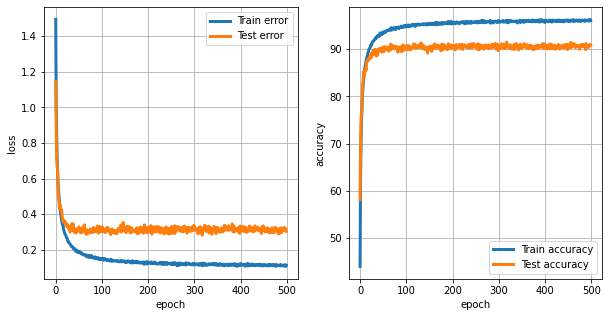

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [11]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5,100-sum(test_accuracy_history[-5:])/5)

Accuracy: 90.83203125 9.16796875
